[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kinalmehta/Reinforcement-Learning-Notebooks/blob/master/Policy%20Gradients%20and%20Actor%20Critic/ActorCritic_torch.ipynb)

### Basic Setup step in **Colab**

In [ ]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari,box2d,classic_control] > /dev/null 2>&1 # change to gym[atari,box2d,classic_control]

In [ ]:
# %tensorflow_version 2.x
# %tensorflow_version 1.x


#### Adding a virtual display for rendering

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

#### Uncomment below to connect to drive to save model and video outputs

In [ ]:

# from google.colab import drive
# drive.mount('/content/gdrive')

# root_path = 'gdrive/My Drive/Colab Notebooks/RL/'
# import os
# os.chdir(root_path)

### Standard imports and notebook setup

In [1]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

In [2]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[-1]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)

        # you can add "loop" after autoplay to keep the video looping after it ends
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                     controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")


def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

## Actor Critic Algorithm

### List of environments that can be used with this version of PG

In [3]:
env_list = ["CartPole-v0", "LunarLander-v2", "MsPacman-ram-v0", "CartPole-v0", "MountainCar-v0", "Breakout-ram-v4", "Acrobot-v1"]

env_to_use = env_list[0]

### Selecting the environment and exploring it

In [4]:
env = wrap_env(gym.make(env_to_use))

#check out the environment's action and observation space!
print(env.action_space)
print(env.observation_space)

from gym import spaces
assert isinstance(env.observation_space, spaces.Box), print("State space should be continuous")
assert len(env.observation_space.shape)==1, print("State space should be 1-D")
assert isinstance(env.action_space, spaces.Discrete), print("Action space should be discrete")

observation = env.reset()
while True:
    env.render()
    #your agent goes here
    action = env.action_space.sample() # selecting a random action from the action space
    observation, reward, done, info = env.step(action) 
    if done: 
        break
    # break

env.close()
show_video()

Discrete(2)
Box(4,)


### Defining the Network to be used

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.actor = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.actor(x)

class Critic(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Critic, self).__init__()
        torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.critic = nn.Linear(fc2_units, 1)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.critic(x)

class PGLoss(nn.Module):
    def forward(self, policy, act, rew_wt):
        logp = policy.log_prob(act)
        return -(logp * rew_wt).mean()


### Defining the agent

In [6]:
import torch
import torch.optim as optim

from torch.distributions.categorical import Categorical

from collections import defaultdict

class Agent:
    def __init__(self, env, batch_size, device='cpu'):
        self.env = env
        self.device = device
        
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n

        self.actor_network = Actor(self.state_size, self.action_size, 4).to(self.device)
        self.critic_network = Critic(self.state_size, 4).to(self.device)

        self.actor_loss = PGLoss()
        self.critic_loss = nn.MSELoss()
        self.batch_size = batch_size


        self.train_stats = defaultdict(list)

    def get_policy(self, obs):
        net_op = self.actor_network(torch.as_tensor(obs, dtype=torch.float32).to(self.device))
        return Categorical(logits=net_op.cpu())
    def get_critic_value(self,obs):
        return self.critic_network(torch.as_tensor(obs, dtype=torch.float32).to(self.device)).cpu()
    def get_action(self, policy):
        return policy.sample().item()

    def get_episode_batch(self):
        batch_obs = []
        batch_action = []
        batch_weights = []
        batch_critic = []
        batch_returns = []
        batch_lengths = []

        cur_obs = self.env.reset()
        episode_rewards = []
        episode_critic_op = []
        done = False

        while True:
            batch_obs.append(cur_obs.copy())
            
            policy = self.get_policy(cur_obs)
            critic_op = self.get_critic_value(cur_obs)
            cur_action = self.get_action(policy)
            cur_obs, cur_reward, done, _ = self.env.step(cur_action)

            batch_action.append(cur_action)
            batch_critic.append(critic_op)
            episode_rewards.append(cur_reward)
            
            if done:
                episode_return, episode_length = sum(episode_rewards), len(episode_rewards)
                
                batch_returns.append(episode_return)
                batch_lengths.append(episode_length)
                
                def get_reward_to_go(rewards_list, gamma=1):
                    rtg = []
                    sum_rewards = 0
                    for i in rewards_list[::-1]:
                        sum_rewards = i + sum_rewards*gamma
                        rtg.append(sum_rewards)
                    return rtg[::-1]
                batch_weights += get_reward_to_go(episode_rewards, 0.9)
                
                if len(batch_obs) > self.batch_size:
                    break
                
                cur_obs, done, episode_rewards, episode_critic_op = self.env.reset(), False, [], []
        return batch_obs, batch_action, batch_weights, batch_critic, batch_returns, batch_lengths

    def train(self, epochs):
        actor_optimizer = optim.Adam(self.actor_network.parameters(), lr=1e-2)
        critic_optimizer = optim.Adam(self.critic_network.parameters(), lr=1e-2)

        for i in range(epochs):
            obs, act, rew_wt, critic_op, eps_rew, eps_len = self.get_episode_batch()
            obs = torch.as_tensor(obs)
            act = torch.as_tensor(act)
            rew_wt = torch.as_tensor(rew_wt)
            critic_op = torch.cat(critic_op)
            
            actor_optimizer.zero_grad()
            critic_optimizer.zero_grad()
            
            actor_loss_val = self.actor_loss(self.get_policy(obs), act, rew_wt-critic_op.detach())
            critic_loss_val = self.critic_loss(critic_op, rew_wt)

            actor_loss_val.backward()
            actor_optimizer.step()

            critic_loss_val.backward()
            critic_optimizer.step()

            self.train_stats["actor_loss"] += [actor_loss_val.item()]
            self.train_stats["critic_loss"] += [critic_loss_val.item()]
            # self.train_stats["total_loss"] += [loss.item()]
            self.train_stats["rewards"] += [np.mean(eps_rew)]

            print("Epoch:", i, actor_loss_val.item(), critic_loss_val.item(), np.mean(eps_rew), np.mean(eps_len))
        
    def train_ac(self, epochs):
        actor_optimizer = optim.Adam(self.actor_network.parameters(), lr=1e-2)
        critic_optimizer = optim.Adam(self.critic_network.parameters(), lr=1e-2)

        cur_obs = self.env.reset()
        policy = self.get_policy(cur_obs)
        critic_op = self.get_critic_value(cur_obs)

        rewards = []
        ep_reward = 0

        actor_optimizer.zero_grad()
        critic_optimizer.zero_grad()
        
        for i in range(epochs):

            cur_action = self.get_action(policy)
            nxt_obs, cur_reward, done, _ = self.env.step(cur_action)
            # print(nxt_obs, cur_reward, done, critic_op, cur_action)
            ep_reward += cur_reward

            if done:
                nxt_obs = self.env.reset()
                rewards.append(ep_reward)
                ep_reward = 0

            nxt_policy = self.get_policy(nxt_obs)
            nxt_critic_op = self.get_critic_value(nxt_obs)

            # print("[INFO] Reward", cur_reward, nxt_critic_op)
            target_ret = cur_reward + 0.9*nxt_critic_op.detach()*(1-done)

            
            actor_loss_val = self.actor_loss(policy, torch.tensor([cur_action]), target_ret-critic_op.item())
            # print(critic_op, target_ret)
            critic_loss_val = self.critic_loss(critic_op, target_ret)

            actor_loss_val.backward()

            critic_loss_val.backward()

            if (i+1)%100==0:
                actor_optimizer.step()
                critic_optimizer.step()
                actor_optimizer.zero_grad()
                critic_optimizer.zero_grad()

            policy = nxt_policy
            cur_obs = nxt_obs
            critic_op = nxt_critic_op

            # break
            if (i+1)%5000==0:
                self.train_stats["actor_loss"] += [actor_loss_val.item()]
                self.train_stats["critic_loss"] += [critic_loss_val.item()]
                self.train_stats["rewards"] += [np.mean(rewards)]
                print("Epoch:", i, actor_loss_val.item(), critic_loss_val.item(), np.mean(rewards))
                rewards = []

    
    def plot_train_stats(self):
        if len(self.train_stats)==0:
            print("first train to print train stats")
        for i in self.train_stats:
            plt.plot(self.train_stats[i])
            plt.xlabel("Epoch")
            plt.ylabel(i)
            plt.show()
        return



### Creating Agent's instance and using it to train

In [7]:
print("GPU available:", torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env = wrap_env(gym.make(env_to_use))

agent = Agent(env, batch_size=5000, device=device)
agent.train_ac(100000)
# agent.train(100)



GPU available: True
Epoch: 4999 -0.0 0.05379673093557358 10.921225382932166
Epoch: 9999 -0.0 0.0010177879594266415 9.357009345794392
Epoch: 14999 -0.0 0.00011471944162622094 9.357677902621722
Epoch: 19999 1.33447201733361e-07 4.2358624341432005e-05 9.337686567164178
Epoch: 24999 -2.701199264265597e-09 7.366907084360719e-09 9.363295880149813
Epoch: 29999 -0.0 0.0001007594182738103 9.355805243445692
Epoch: 34999 -3.6282472137827426e-07 0.00011815645848400891 9.388367729831144
Epoch: 39999 -0.0 0.10595064610242844 9.330841121495327
Epoch: 44999 -0.0 9.713243343867362e-06 9.353271028037383
Epoch: 49999 -7.465132512152195e-09 6.127380765974522e-05 9.35140186915888
Epoch: 54999 -0.0 0.0006742851692251861 9.349532710280373
Epoch: 59999 -0.0 0.00016033663996495306 9.336448598130842
Epoch: 64999 -0.0 0.00012175994197605178 9.345794392523365
Epoch: 69999 -0.0 0.08298176527023315 9.322761194029852
Epoch: 74999 -0.0 0.030249837785959244 9.345794392523365
Epoch: 79999 -0.0 0.00014520615513902158 9.

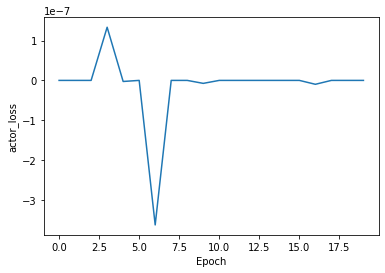

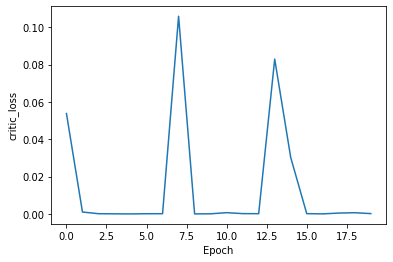

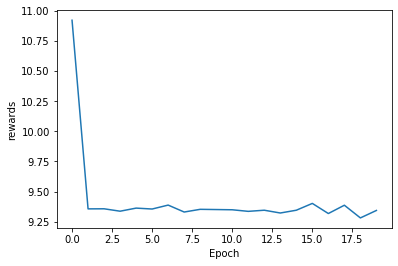

In [8]:
agent.plot_train_stats()

In [9]:
# watch the trained agent
env = wrap_env(gym.make(env_to_use))
state = env.reset()
done=False
while not done:
    policy = agent.get_policy(state)
    action = agent.get_action(policy)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break
        
env.close()
show_video()